In [98]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 
import os
import gdown
import matplotlib.pyplot as plt

In [2]:
irish_lyrics_eof_id = "15UqmiIm0xwh9mt0IYq2z3jHaauxQSTQT"
data_path = "../data"
data_folder_path = os.path.join(data_path, "C3E4-IrishLyrics/")

In [3]:
os.makedirs(data_folder_path)

# Irish lyrics
gdown.download(id=irish_lyrics_eof_id, output=data_folder_path)

Downloading...
From: https://drive.google.com/uc?id=15UqmiIm0xwh9mt0IYq2z3jHaauxQSTQT
To: /Users/olestole/code/kurs/tensorflow_specialty/data/C3E4-IrishLyrics/irish-lyrics-eof.txt
100%|██████████| 69.0k/69.0k [00:00<00:00, 509kB/s]


'../data/C3E4-IrishLyrics/irish-lyrics-eof.txt'

In [7]:
irish_lyrics_path = os.path.join(data_folder_path, "irish-lyrics-eof.txt")
data = open(irish_lyrics_path).read()

In [9]:
# Create the corpus by parsin the raw text
corpus = data.lower().split("\n")

# Tokenize the corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index

# +1 because we didn't provide a oov_token
total_words = len(word_index) + 1


In [91]:
# Create the training data by building xs and ys from the padded sequences

# Create n_gram_sequences
input_sequences = []
for sentence in corpus:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    # Want the smallest sentence to be 2 so that 1 can be X and 1 can be Y
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Find the longest sequence to set pad_length
max_length = max([len(x) for x in input_sequences])

# Pad the sequences
padded = pad_sequences(input_sequences, maxlen=max_length, padding="pre")

# Use all but the last element as xs and the last for ys
xs, labels = padded[:, : -1], padded[:, -1]

# Create one-shot instances of the ys
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [93]:
# Create the model
embedding_dims = 64
# Subtract 1 since it's without the last word_index
input_length = max_length - 1

# TODO: Seems to overfit at acc ~0.78. Try changing the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, embedding_dims, input_length=input_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(total_words, activation='softmax'),
])

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

2021-12-02 14:04:19.755092: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 64)            172160    
                                                                 
 bidirectional (Bidirectiona  (None, 100)              46000     
 l)                                                              
                                                                 
 dense (Dense)               (None, 2690)              271690    
                                                                 
Total params: 489,850
Trainable params: 489,850
Non-trainable params: 0
_________________________________________________________________


In [116]:
history = model.fit(xs, ys, epochs=50, verbose=2)

Epoch 1/50
377/377 - 4s - loss: 0.7839 - accuracy: 0.7894 - 4s/epoch - 10ms/step
Epoch 2/50
377/377 - 3s - loss: 0.8305 - accuracy: 0.7774 - 3s/epoch - 9ms/step
Epoch 3/50
377/377 - 3s - loss: 0.8364 - accuracy: 0.7747 - 3s/epoch - 9ms/step
Epoch 4/50
377/377 - 4s - loss: 0.8460 - accuracy: 0.7709 - 4s/epoch - 10ms/step
Epoch 5/50
377/377 - 4s - loss: 0.8405 - accuracy: 0.7715 - 4s/epoch - 10ms/step
Epoch 6/50
377/377 - 4s - loss: 0.8269 - accuracy: 0.7769 - 4s/epoch - 10ms/step
Epoch 7/50
377/377 - 4s - loss: 0.8167 - accuracy: 0.7786 - 4s/epoch - 10ms/step
Epoch 8/50
377/377 - 3s - loss: 0.7806 - accuracy: 0.7869 - 3s/epoch - 9ms/step
Epoch 9/50
377/377 - 3s - loss: 0.7605 - accuracy: 0.7937 - 3s/epoch - 9ms/step
Epoch 10/50
377/377 - 3s - loss: 0.7680 - accuracy: 0.7925 - 3s/epoch - 9ms/step
Epoch 11/50
377/377 - 3s - loss: 0.8130 - accuracy: 0.7789 - 3s/epoch - 9ms/step
Epoch 12/50
377/377 - 3s - loss: 0.8109 - accuracy: 0.7774 - 3s/epoch - 9ms/step
Epoch 13/50
377/377 - 3s - loss:

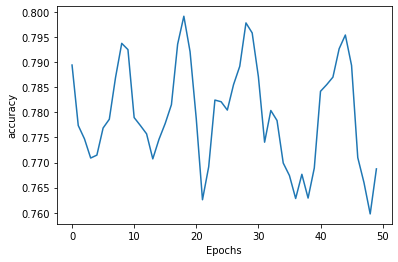

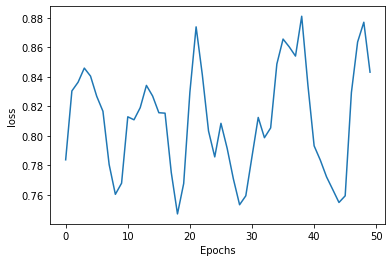

In [117]:
def plot_graphs(history, metric):
    metric_data = history.history[metric]
    plt.plot(metric_data)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [124]:
import random

def generate_text(seed_text, length):
	line_length = random.randint(6, 12)
	line_count = 0

	for _ in range(length):
		token_list = tokenizer.texts_to_sequences([seed_text])[0]
		token_list = pad_sequences([token_list], maxlen=max_length-1, padding='pre')
		predicted = model.predict(token_list, verbose=0)
		predicted_index = np.argmax(predicted)
		output_word = ""
		
		word_values = list(tokenizer.word_index.values())
		word_keys = list(tokenizer.word_index.keys())
	
		predicted_word_index = word_values.index(predicted_index)
		predicted_word = word_keys[predicted_word_index]

		seed_text += " " + predicted_word

		if (line_count == line_length):
			seed_text += "\n"
			line_count = 0
			line_length = random.randint(6, 12)
		line_count += 1

	return seed_text

seed_text = "Laurence went Dublin with girls"
generated_text = generate_text(seed_text, 20)
print(generated_text)

Laurence went Dublin with girls and boys twas young fellows of dublin town to antrim town to hades
 them barley for instead rising law agin
